In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix

In [3]:
vocab = open('20news-bydate/vocabulary.txt', 'r').read().split()
Y_train = np.array(list(map(int, open('20news-bydate/matlab/train.label', 'r').read().split()))) - 1
Y_test = np.array(list(map(int, open('20news-bydate/matlab/test.label', 'r').read().split()))) - 1
m_train = len(Y_train)
m_test = len(Y_test)
LEN_VOCAB = len(vocab)

In [4]:
X_train_raw = pd.read_csv('20news-bydate/matlab/train.data', sep=' ', header=None, names=['doc', 'word', 'count'])
X_test_raw = pd.read_csv('20news-bydate/matlab/test.data', sep=' ', header=None, names=['doc', 'word', 'count'])

In [5]:
X_train = X_train_raw.groupby('doc').apply(lambda x: dict(zip(x['word'], x['count'])))
X_test = X_test_raw.groupby('doc').apply(lambda x: dict(zip(x['word'], x['count'])))

In [29]:
def from_dic_to_array(dic):
    ar = np.zeros(LEN_VOCAB)
    for i, j in dic.items():
        ar[i-1] = j
    return ar

In [30]:
class Net(nn.Module):

    def __init__(self, input_size=LEN_VOCAB, output_size=20, hidden_layer_size=100):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_layer_size, bias=True)
        self.fc2 = nn.Linear(hidden_layer_size, output_size, bias=True)
        torch.nn.init.xavier_uniform(self.fc1.weight)
        torch.nn.init.xavier_uniform(self.fc2.weight)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x

net = Net()
print(net)
criterion = nn.CrossEntropyLoss()

import torch.optim as optim

Net(
  (fc1): Linear(in_features=61188, out_features=100)
  (fc2): Linear(in_features=100, out_features=20)
)


In [31]:
import math
def random_mini_batches_idx(m, mini_batch_size = 64, seed = 0):
    permutation = np.random.permutation(m)
    num_complete_minibatches = int(math.floor(m/mini_batch_size)) # number of mini batches of size mini_batch_size in your partitionning
    list_of_indices = []
    for k in range(0, num_complete_minibatches):
        list_of_indices.append(list(permutation[k * mini_batch_size: k * mini_batch_size + mini_batch_size]))
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        list_of_indices.append(list(permutation[num_complete_minibatches * mini_batch_size : m]))
    return list_of_indices

In [32]:
def get_accuracy(net, X, Y):
    minibatches_indices = random_mini_batches_idx(len(X), mini_batch_size=10)
    total_correct = 0
    total_examples = 0
    for i, indices in enumerate(minibatches_indices):
        # get the inputs
        X_minibatch = X.iloc[indices]
        inputs = np.vstack(X_minibatch.apply(from_dic_to_array).tolist())
        labels = Y[indices]
        inputs = torch.from_numpy(inputs).float()
        true_labels = torch.from_numpy(labels).long()
        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(true_labels)
        # forward + backward + optimize
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == true_labels).sum()
        total_examples += len(indices)
    return float(total_correct)/total_examples

In [36]:
def model(X_train, X_test, Y_train, Y_test, n_epochs=3, weight_decay=0,
          lr=0.01, momentum=.9, mini_batch_size=8, seed=0, print_every=None):
    net = Net()
    if print_every is None:
        print_every = int(len(X_train) / (4 * mini_batch_size))
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    nets = [net]
    acc_train = get_accuracy(net, X_train, Y_train)
    acc_test = get_accuracy(net, X_test, Y_test)
    print ("Accuracy on training set: {0}".format(acc_train))
    print ("Accuracy on test set: {0}".format(acc_test))
    accuracies_train = [acc_train]
    accuracies_test = [acc_test]
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        minibatches_indices = random_mini_batches_idx(m_train, mini_batch_size=mini_batch_size, seed=seed)
        running_loss = 0.0
        total_correct = 0
        total_examples = 0
        for i, indices in enumerate(minibatches_indices):
            # get the inputs
            X_minibatch = X_train.iloc[indices]
            inputs = np.vstack(X_minibatch.apply(from_dic_to_array).tolist())
            labels = Y_train[indices]
            inputs = torch.from_numpy(inputs).float()
            true_labels = torch.from_numpy(labels).long()
            # wrap them in Variable
            inputs, labels = Variable(inputs), Variable(true_labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.data[0]
            if i % print_every == print_every - 1:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.4f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
        acc_train = get_accuracy(net, X_train, Y_train)
        acc_test = get_accuracy(net, X_test, Y_test)
        print ("Accuracy on training set: {0}".format(acc_train))
        print ("Accuracy on test set: {0}".format(acc_test))
        accuracies_train.append(acc_train)
        accuracies_test.append(acc_test)
        nets.append(net)
    print('Finished Training')
    return nets, accuracies_train, accuracies_test

In [160]:
nets, accuracies_train, accuracies_test = model(X_train=X_train, X_test=X_test,
                                                             Y_train=Y_train, Y_test=Y_test,
                                                            n_epochs=20, lr=0.01)

Accuracy on training set: 0.04969385038601473
Accuracy on test set: 0.05063291139240506
[1,   352] loss: 0.5123
[1,   704] loss: 0.4771
[1,  1056] loss: 0.4574
[1,  1408] loss: 0.4466
Accuracy on training set: 0.5426390984115715
Accuracy on test set: 0.42025316455696204
[2,   352] loss: 0.4315
[2,   704] loss: 0.4364
[2,  1056] loss: 0.4236
[2,  1408] loss: 0.4208
Accuracy on training set: 0.7405271097701659
Accuracy on test set: 0.5905396402398401
[3,   352] loss: 0.4098
[3,   704] loss: 0.4063
[3,  1056] loss: 0.4094
[3,  1408] loss: 0.4119
Accuracy on training set: 0.8199485313692431
Accuracy on test set: 0.6475682878081279
[4,   352] loss: 0.4049
[4,   704] loss: 0.3997
[4,  1056] loss: 0.4047
[4,  1408] loss: 0.3989
Accuracy on training set: 0.803354334901056
Accuracy on test set: 0.6157228514323784
[5,   352] loss: 0.3933
[5,   704] loss: 0.3922
[5,  1056] loss: 0.3937
[5,  1408] loss: 0.3915
Accuracy on training set: 0.8570414411216611
Accuracy on test set: 0.6567621585609593
[6

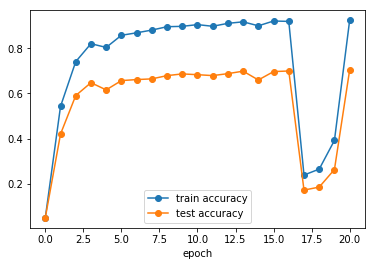

In [165]:
plt.plot(accuracies_train, '-o', label='train accuracy')
plt.plot(accuracies_test, '-o', label='test accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Preprocessing

## TF-IDF

In [15]:
number_of_documents_appear = X_train_raw.groupby('word').size().to_dict()
idf = {i: np.log(float(len(X_train)) / j) for i, j in number_of_documents_appear.items()}
def make_tfidf_dataframe(X):
    X.name = 'countDict'
    X_tfidf = X.reset_index()
    X_tfidf['n_words'] = X_tfidf.apply(lambda x: sum(list(x.countDict.values())), axis=1)
    X_tfidf['tf'] = X_tfidf.apply(lambda x: {i: j/float(x.n_words) for i, j in x.countDict.items()}, axis=1)
    X_tfidf['tfIDF'] = X_tfidf.apply(lambda x: {i: j * idf[i] if i in idf else 0 for i, j in x.tf.items()}, axis=1)
    X_tfidf.index = X_tfidf.doc
    return X_tfidf.tfIDF

In [16]:
X_tfidf_train = make_tfidf_dataframe(X_train)
X_tfidf_test = make_tfidf_dataframe(X_test)

In [175]:
nets_tfidf, accuracies_train_tfidf, accuracies_test_tfidf = model(X_train=X_tfidf_train,
                                                      X_test=X_tfidf_test,
                                                      Y_train=Y_train, Y_test=Y_test,
                                                      n_epochs=20, 
                                                      #mini_batch_size=64,
                                                      lr=0.01)

Accuracy on training set: 0.04161859969828734
Accuracy on test set: 0.04263824117255163
[1,   352] loss: 0.5271
[1,   704] loss: 0.5269
[1,  1056] loss: 0.5267
[1,  1408] loss: 0.5267
Accuracy on training set: 0.052622237998047744
Accuracy on test set: 0.05223184543637575
[2,   352] loss: 0.5264
[2,   704] loss: 0.5264
[2,  1056] loss: 0.5264
[2,  1408] loss: 0.5261
Accuracy on training set: 0.05297719407223356
Accuracy on test set: 0.05289806795469687
[3,   352] loss: 0.5261
[3,   704] loss: 0.5267
[3,  1056] loss: 0.5257
[3,  1408] loss: 0.5257
Accuracy on training set: 0.11136746827580087
Accuracy on test set: 0.09620253164556962
[4,   352] loss: 0.5257
[4,   704] loss: 0.5252
[4,  1056] loss: 0.5263
[4,  1408] loss: 0.5262
Accuracy on training set: 0.07436329754192919
Accuracy on test set: 0.0626249167221852
[5,   352] loss: 0.5253
[5,   704] loss: 0.5254
[5,  1056] loss: 0.5261
[5,  1408] loss: 0.5253
Accuracy on training set: 0.07010382465169936
Accuracy on test set: 0.0620919387

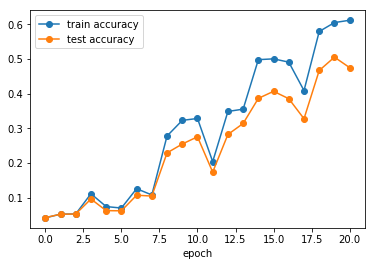

In [176]:
plt.plot(accuracies_train_tfidf, '-o', label='train accuracy')
plt.plot(accuracies_test_tfidf, '-o', label='test accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Standardization

In [46]:
word_list = X_train_raw.groupby('word')['count'].apply(list)
word_stddevs = word_list.apply(lambda x: np.std(x + [0] * (m_train - len(x)))).to_dict()
word_means = word_list.apply(lambda x: np.mean(x + [0] * (m_train - len(x)))).to_dict()
def make_standard(X, epsilon=1e-5):
    X_stan = X.apply(lambda x: {i : (j-word_means[i])/(word_stddevs[i] + epsilon) if i in word_means else 0 for i, j in x.items()})
    return X_stan

In [47]:
X_stan_train = make_standard(X_train)
X_stan_test = make_standard(X_test)

In [52]:
nets_stan, accuracies_train_stan, accuracies_test_stan = model(X_train=X_stan_train,
                                                              X_test=X_stan_test,
                                                              Y_train=Y_train, Y_test=Y_test,
                                                              n_epochs=20, 
                                                              weight_decay=0.1,
                                                              #mini_batch_size=64,
                                                              lr=0.01)

Accuracy on training set: 0.05208980388676901
Accuracy on test set: 0.049966688874083946
[1,   352] loss: 0.4975
[1,   704] loss: 0.4961
[1,  1056] loss: 0.4966
[1,  1408] loss: 0.4948
Accuracy on training set: 0.43118289111722424
Accuracy on test set: 0.35562958027981345
[2,   352] loss: 0.4928
[2,   704] loss: 0.4941
[2,  1056] loss: 0.4938
[2,  1408] loss: 0.4941
Accuracy on training set: 0.36808944893069484
Accuracy on test set: 0.3055296469020653
[3,   352] loss: 0.4915
[3,   704] loss: 0.4938
[3,  1056] loss: 0.4947
[3,  1408] loss: 0.4937
Accuracy on training set: 0.389386813381844
Accuracy on test set: 0.33031312458361095
[4,   352] loss: 0.4910
[4,   704] loss: 0.4934
[4,  1056] loss: 0.4940
[4,  1408] loss: 0.4949
Accuracy on training set: 0.3500754281657645
Accuracy on test set: 0.3039307128580946
[5,   352] loss: 0.4914
[5,   704] loss: 0.4952
[5,  1056] loss: 0.4935
[5,  1408] loss: 0.4937
Accuracy on training set: 0.3790930872304552
Accuracy on test set: 0.307395069953364

KeyboardInterrupt: 

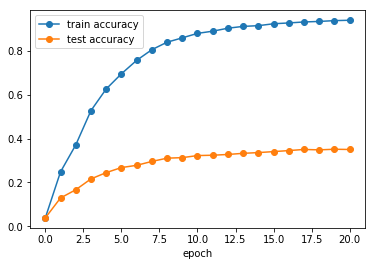

In [180]:
plt.plot(accuracies_train_stan, '-o', label='train accuracy')
plt.plot(accuracies_test_stan, '-o', label='test accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()